# Set up

In [1]:
import pandas as pd
import patsy
import numpy as np
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import PredefinedSplit, GridSearchCV, cross_val_score
from sklearn.decomposition import PCA
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

/home/tom/footbot/venv/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


# Getting data

In [2]:
file_name = '../csvs/element_gameweek_features_v06.csv'

In [3]:
element_gameweek_df = pd.read_csv(file_name)

In [4]:
current_event = 20

In [5]:
last_train_event = 15

In [6]:
element_gameweek_df =\
element_gameweek_df[
    (element_gameweek_df['event'] <= current_event)
]

In [7]:
element_gameweek_df.fillna(
    element_gameweek_df[element_gameweek_df['event'] <= last_train_event].mean(),
    inplace=True
)

In [8]:
element_gameweek_df = element_gameweek_df[element_gameweek_df['rolling_avg_minutes_element_p3'] >= 60]

# Modelling data

## Splitting data

In [9]:
test_fold = [-1 if i <= last_train_event else 0 for i in element_gameweek_df['event']]
ps = PredefinedSplit(test_fold)

In [10]:
for train_index, test_index in ps.split():
    element_gameweek_df_train, element_gameweek_df_test = \
    element_gameweek_df.copy().iloc[train_index], element_gameweek_df.copy().iloc[test_index]

## Building model

In [11]:
formula = \
'total_points ~ C(element_type) + ' + \
' + '.join([i for i in element_gameweek_df.columns if i not in
 [
     'safe_web_name',
     'element',
     'event',
     'fixture',
     'team',
     'opposition_team',
     'element_type',
     'minutes',
     'rolling_value_points',
     'total_points',
     
     'expected_total_points_against_opposition_team',
     'rolling_avg_total_points_element_home',
     'rolling_max_total_points_element',
     'rolling_avg_bps_element',
     'expected_total_points_element_home_away',
     'rolling_avg_total_points_element_away',
     'rolling_avg_total_points_own_team',
     'rolling_avg_total_points_against_opposition_team',
     'rolling_avg_minutes_element',
     'rolling_avg_total_points_opposition_team',
     'rolling_avg_dribbles_element',
     'rolling_avg_total_points_against_opposition_team_element_type',
     'rolling_avg_total_points_against_opposition_team_element_type_away',
     'rolling_avg_total_points_against_opposition_team_element_type_home',
     'rolling_avg_goals_conceded_element',
     'rolling_avg_completed_passes_element',
     'rolling_avg_total_points_element_type',
     'rolling_avg_recoveries_element',
 ]])

In [12]:
print(formula)

total_points ~ C(element_type) + was_home + is_sunday + is_weekday + is_early + is_late + value + rolling_avg_total_points_element + has_high_points_ever_element + rolling_avg_bonus_element + rolling_avg_goals_scored_element + rolling_avg_clean_sheets_element + rolling_avg_assists_element + rolling_avg_key_passes_element + rolling_avg_winning_goals_element + rolling_avg_tackled_element + rolling_avg_clearances_blocks_interceptions_element + rolling_avg_big_chances_created_element + rolling_avg_target_missed_element + rolling_avg_fouls_element + rolling_avg_tackles_element + rolling_avg_open_play_crosses_element + rolling_avg_offside_element + rolling_avg_big_chances_missed_element + rolling_avg_saves_element + rolling_avg_attempted_passes_element + rolling_avg_errors_leading_to_goal_element + rolling_avg_errors_leading_to_goal_attempt_element + rolling_avg_own_goals_element + rolling_avg_penalties_concededd_element + rolling_avg_penalties_missed_element + rolling_avg_penalties_saved_el

In [13]:
y, X = patsy.dmatrices(formula, element_gameweek_df, return_type='matrix')

In [14]:
for train_index, test_index in ps.split():
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

## Selecting features

In [ ]:
estimator = XGBRegressor(
    n_estimators=100,
    min_samples_leaf=0.178,
    max_features=0.419,
    learning_rate=0.0102
)

selector = RFECV(estimator, step=1,
                 scoring='neg_mean_squared_error',
                 cv=ps, n_jobs=1, verbose=1)
selector.fit(
    X,
    y.ravel()
)

In [ ]:
sum(selector.support_)

In [ ]:
list(pd.Series(X.design_info.column_names)[selector.support_])

In [ ]:
X_sel = X[:,selector.support_]
X_train_sel = X_train[:,selector.support_]
X_test_sel = X_test[:,selector.support_]

## Tuning model

### GP tuner

In [114]:
space  = [
    Real(0.01, 0.1, 'uniform', name='learning_rate'),
    Real(0.01, 1.0, 'uniform', name='colsample_bylevel'),
    Real(10**-7, 10**-1, 'log-uniform', name='reg_lambda'),
    Integer(1, 100, name='max_depth'),
]

In [115]:
gp_model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    subsample=1.0
)

@use_named_args(space)
def objective(**params):
    gp_model.set_params(**params)

    return -np.mean(
        cross_val_score(
            gp_model,
            X,
#             X_sel,
            y.ravel(),
            cv=ps,
            n_jobs=1,
            scoring="neg_mean_squared_error"))

In [116]:
res_gp_arr = []
for i in range(1, 6):
    print('minimisation iteration', i)
    res_gp = gp_minimize(objective, space, n_calls=100, verbose=2)
    res_gp_arr.append(res_gp)

minimisation iteration 1
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 3.1479
Function value obtained: 9.7407
Current minimum: 9.7407
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.2731
Function value obtained: 9.5286
Current minimum: 9.5286
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 5.1648
Function value obtained: 10.9955
Current minimum: 9.5286
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 4.8632
Function value obtained: 10.3036
Current minimum: 9.5286
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 2.2367
Function value obtained: 9.6972
Current minimum: 9.5286
Iteratio

Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 1.6717
Function value obtained: 9.6944
Current minimum: 9.3984
Iteration No: 42 started. Searching for the next optimal point.
Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 1.5368
Function value obtained: 9.7599
Current minimum: 9.3984
Iteration No: 43 started. Searching for the next optimal point.
Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 5.6156
Function value obtained: 16.0117
Current minimum: 9.3984
Iteration No: 44 started. Searching for the next optimal point.
Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 5.4276
Function value obtained: 9.5547
Current minimum: 9.3984
Iteration No: 45 started. Searching for the next optimal point.
Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 1.5149
Function value obtained: 9.4414
Current minimum: 9.3984
Iteration No: 46 started. Se

Iteration No: 81 ended. Search finished for the next optimal point.
Time taken: 2.8187
Function value obtained: 9.4702
Current minimum: 9.3615
Iteration No: 82 started. Searching for the next optimal point.
Iteration No: 82 ended. Search finished for the next optimal point.
Time taken: 1.8386
Function value obtained: 9.4733
Current minimum: 9.3615
Iteration No: 83 started. Searching for the next optimal point.
Iteration No: 83 ended. Search finished for the next optimal point.
Time taken: 1.9222
Function value obtained: 9.4343
Current minimum: 9.3615
Iteration No: 84 started. Searching for the next optimal point.
Iteration No: 84 ended. Search finished for the next optimal point.
Time taken: 1.7118
Function value obtained: 9.5167
Current minimum: 9.3615
Iteration No: 85 started. Searching for the next optimal point.
Iteration No: 85 ended. Search finished for the next optimal point.
Time taken: 3.8588
Function value obtained: 9.5996
Current minimum: 9.3615
Iteration No: 86 started. Sea

Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 6.2792
Function value obtained: 9.6259
Current minimum: 9.3787
Iteration No: 23 started. Searching for the next optimal point.
Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 3.9924
Function value obtained: 10.6619
Current minimum: 9.3787
Iteration No: 24 started. Searching for the next optimal point.
Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 5.2452
Function value obtained: 9.5560
Current minimum: 9.3787
Iteration No: 25 started. Searching for the next optimal point.
Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 7.9662
Function value obtained: 9.4563
Current minimum: 9.3787
Iteration No: 26 started. Searching for the next optimal point.
Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 6.1871
Function value obtained: 9.6786
Current minimum: 9.3787
Iteration No: 27 started. Se

Iteration No: 62 ended. Search finished for the next optimal point.
Time taken: 8.0997
Function value obtained: 9.3578
Current minimum: 9.3450
Iteration No: 63 started. Searching for the next optimal point.
Iteration No: 63 ended. Search finished for the next optimal point.
Time taken: 6.0809
Function value obtained: 9.3642
Current minimum: 9.3450
Iteration No: 64 started. Searching for the next optimal point.
Iteration No: 64 ended. Search finished for the next optimal point.
Time taken: 12.2496
Function value obtained: 9.7164
Current minimum: 9.3450
Iteration No: 65 started. Searching for the next optimal point.
Iteration No: 65 ended. Search finished for the next optimal point.
Time taken: 4.0357
Function value obtained: 9.4797
Current minimum: 9.3450
Iteration No: 66 started. Searching for the next optimal point.
Iteration No: 66 ended. Search finished for the next optimal point.
Time taken: 9.8826
Function value obtained: 9.3493
Current minimum: 9.3450
Iteration No: 67 started. Se

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 8.1293
Function value obtained: 9.9296
Current minimum: 9.6939
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 8.2143
Function value obtained: 9.6618
Current minimum: 9.6618
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.2469
Function value obtained: 9.6325
Current minimum: 9.6325
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 1.0866
Function value obtained: 9.9311
Current minimum: 9.6325
Iteration No: 6 started. Evaluating function at random point.
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 6.8356
Function value obtained: 10.0497
Current minimum: 9.6325
Iteration No: 7 started. Evaluating function at random point.
Iteration No: 7 ended. Evaluation 

Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 1.8793
Function value obtained: 9.9192
Current minimum: 9.3535
Iteration No: 44 started. Searching for the next optimal point.
Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 1.8370
Function value obtained: 9.4449
Current minimum: 9.3535
Iteration No: 45 started. Searching for the next optimal point.
Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 1.2920
Function value obtained: 9.4415
Current minimum: 9.3535
Iteration No: 46 started. Searching for the next optimal point.
Iteration No: 46 ended. Search finished for the next optimal point.
Time taken: 1.4958
Function value obtained: 9.4673
Current minimum: 9.3535
Iteration No: 47 started. Searching for the next optimal point.
Iteration No: 47 ended. Search finished for the next optimal point.
Time taken: 3.6565
Function value obtained: 9.9362
Current minimum: 9.3535
Iteration No: 48 started. Sea

Iteration No: 83 ended. Search finished for the next optimal point.
Time taken: 3.3388
Function value obtained: 9.3764
Current minimum: 9.3173
Iteration No: 84 started. Searching for the next optimal point.
Iteration No: 84 ended. Search finished for the next optimal point.
Time taken: 3.0268
Function value obtained: 9.3386
Current minimum: 9.3173
Iteration No: 85 started. Searching for the next optimal point.
Iteration No: 85 ended. Search finished for the next optimal point.
Time taken: 3.3802
Function value obtained: 9.5152
Current minimum: 9.3173
Iteration No: 86 started. Searching for the next optimal point.
Iteration No: 86 ended. Search finished for the next optimal point.
Time taken: 3.6718
Function value obtained: 9.4671
Current minimum: 9.3173
Iteration No: 87 started. Searching for the next optimal point.
Iteration No: 87 ended. Search finished for the next optimal point.
Time taken: 2.1251
Function value obtained: 9.4709
Current minimum: 9.3173
Iteration No: 88 started. Sea

Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 4.8730
Function value obtained: 9.5541
Current minimum: 9.4921
Iteration No: 25 started. Searching for the next optimal point.
Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 3.7199
Function value obtained: 9.5155
Current minimum: 9.4921
Iteration No: 26 started. Searching for the next optimal point.
Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 2.9845
Function value obtained: 9.4516
Current minimum: 9.4516
Iteration No: 27 started. Searching for the next optimal point.
Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 4.8840
Function value obtained: 9.5501
Current minimum: 9.4516
Iteration No: 28 started. Searching for the next optimal point.
Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 3.6170
Function value obtained: 9.3993
Current minimum: 9.3993
Iteration No: 29 started. Sea

Iteration No: 64 ended. Search finished for the next optimal point.
Time taken: 2.5690
Function value obtained: 9.7910
Current minimum: 9.3488
Iteration No: 65 started. Searching for the next optimal point.
Iteration No: 65 ended. Search finished for the next optimal point.
Time taken: 2.0827
Function value obtained: 9.4413
Current minimum: 9.3488
Iteration No: 66 started. Searching for the next optimal point.
Iteration No: 66 ended. Search finished for the next optimal point.
Time taken: 6.2180
Function value obtained: 9.7207
Current minimum: 9.3488
Iteration No: 67 started. Searching for the next optimal point.
Iteration No: 67 ended. Search finished for the next optimal point.
Time taken: 2.5982
Function value obtained: 9.4445
Current minimum: 9.3488
Iteration No: 68 started. Searching for the next optimal point.
Iteration No: 68 ended. Search finished for the next optimal point.
Time taken: 2.9282
Function value obtained: 9.4558
Current minimum: 9.3488
Iteration No: 69 started. Sea

Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 1.4847
Function value obtained: 9.6389
Current minimum: 9.3673
Iteration No: 39 started. Searching for the next optimal point.
Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 3.7243
Function value obtained: 9.5865
Current minimum: 9.3673
Iteration No: 40 started. Searching for the next optimal point.
Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 3.6366
Function value obtained: 9.4050
Current minimum: 9.3673
Iteration No: 41 started. Searching for the next optimal point.
Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 3.7388
Function value obtained: 9.3939
Current minimum: 9.3673
Iteration No: 42 started. Searching for the next optimal point.
Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 3.2114
Function value obtained: 9.4354
Current minimum: 9.3673
Iteration No: 43 started. Sea

Iteration No: 78 ended. Search finished for the next optimal point.
Time taken: 6.6539
Function value obtained: 9.5941
Current minimum: 9.3523
Iteration No: 79 started. Searching for the next optimal point.
Iteration No: 79 ended. Search finished for the next optimal point.
Time taken: 4.5909
Function value obtained: 9.5907
Current minimum: 9.3523
Iteration No: 80 started. Searching for the next optimal point.
Iteration No: 80 ended. Search finished for the next optimal point.
Time taken: 3.0330
Function value obtained: 9.4812
Current minimum: 9.3523
Iteration No: 81 started. Searching for the next optimal point.
Iteration No: 81 ended. Search finished for the next optimal point.
Time taken: 2.9609
Function value obtained: 9.4620
Current minimum: 9.3523
Iteration No: 82 started. Searching for the next optimal point.
Iteration No: 82 ended. Search finished for the next optimal point.
Time taken: 4.0847
Function value obtained: 9.5533
Current minimum: 9.3523
Iteration No: 83 started. Sea

In [117]:
# Full features
for i in res_gp_arr:
    print(i.fun)
print('\n')
for i in res_gp_arr:
    print(i.x)

9.361476297392208
9.344432441529257
9.317273739201578
9.344132099109993
9.35227626695803


[0.03687335743068543, 0.17915303272827326, 1e-07, 57]
[0.03259800661659801, 0.18384094809718068, 1e-07, 70]
[0.040074747319803365, 0.13757740073731053, 0.1, 76]
[0.03573758808228153, 0.17886925576817486, 1e-07, 100]
[0.039472023334070475, 0.2049865599913702, 1e-07, 29]


### Grid search

In [106]:
learning_rate = [0.04, 0.05, 0.06]
colsample_bylevel = [0.1, 0.2, 0.3]
reg_lambda = [0.0025, 0.005, 0.0075]
max_depth = [20, 50, 80]

gs_parameters = {
    'learning_rate': learning_rate,
    'colsample_bylevel': colsample_bylevel,
    'reg_lambda': reg_lambda,
    'max_depth': max_depth
}

In [107]:
gs_model = GridSearchCV(
    XGBRegressor(
        objective='reg:squarederror',
        n_estimators=100,
        subsample=1.0),
    gs_parameters,
    scoring=['neg_mean_absolute_error', 'neg_mean_squared_error'],
    refit=False,
    cv=ps,
    error_score=100, n_jobs=1, verbose=1)
gs_model.fit(X, y.ravel())

Fitting 1 folds for each of 243 candidates, totalling 243 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 243 out of 243 | elapsed:  9.3min finished


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             error_score=100,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    object...
                                    subsample=1.0, verbosity=1),
             iid='warn', n_jobs=1,
             param_grid={'colsample_bylevel': [0.19, 0.2, 0.21],
                         'learning_rate': [0.0145, 0.015, 0.0155],
                         'max_depth': [12, 15, 18],
                         'n_estimators': [50, 100, 500],
    

In [108]:
gs_model_df = pd.DataFrame(gs_model.cv_results_)[[
    'param_learning_rate',
    'param_colsample_bylevel',
    'param_reg_lambda',
    'param_max_depth',
    'split0_test_neg_mean_absolute_error',
    'split0_test_neg_mean_squared_error'
]]

gs_model_df

,param_learning_rate,param_colsample_bylevel,param_reg_lambda,param_max_depth,param_n_estimators,split0_test_neg_mean_absolute_error,split0_test_neg_mean_squared_error
0,0.0145,0.19,0.0025,12,50,-2.038467,-11.001903
1,0.0145,0.19,0.005,12,50,-2.039619,-11.009052
2,0.0145,0.19,0.0075,12,50,-2.036096,-10.943199
3,0.0145,0.19,0.0025,12,100,-2.053435,-9.793435
4,0.0145,0.19,0.005,12,100,-2.054756,-9.801678
5,0.0145,0.19,0.0075,12,100,-2.052530,-9.729634
6,0.0145,0.19,0.0025,12,500,-2.183579,-9.439171
7,0.0145,0.19,0.005,12,500,-2.186748,-9.445383
8,0.0145,0.19,0.0075,12,500,-2.186532,-9.402958
9,0.0145,0.19,0.0025,15,50,-2.040613,-10.901043


In [109]:
gs_model_df[
    gs_model_df['split0_test_neg_mean_squared_error'] == \
    gs_model_df['split0_test_neg_mean_squared_error'].max()]

,param_learning_rate,param_colsample_bylevel,param_reg_lambda,param_max_depth,param_n_estimators,split0_test_neg_mean_absolute_error,split0_test_neg_mean_squared_error
124,0.015,0.2,0.005,15,500,-2.16324,-9.229075
205,0.015,0.21,0.005,15,500,-2.16324,-9.229075


# Evaluating model

## XGBoost

In [92]:
model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=500,
    subsample=1.0,
    learning_rate=0.015,
    colsample_bylevel=0.2,
    reg_lambda=0.005,
    max_depth=15,
)

model.fit(X_train, y_train.ravel())

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.2,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.015, max_delta_step=0,
             max_depth=15, min_child_weight=1, missing=None, n_estimators=500,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=0.005, scale_pos_weight=1,
             seed=None, silent=None, subsample=1.0, verbosity=1)

In [93]:
# get predictions for test set
y_pred = model.predict(X_test).flatten()

# calculate cross entropy loss for test set
test_loss = (
    mean_absolute_error(y_test, y_pred),
    mean_squared_error(y_test, y_pred),
    r2_score(y_test, y_pred)
)
test_loss

(2.163240303721609, 9.229074700627082, 0.1131706440320498)

In [94]:
# refit model on all data
model_full = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=500,
    subsample=1.0,
    learning_rate=0.015,
    colsample_bylevel=0.2,
    reg_lambda=0.005,
    max_depth=15
)

model_full.fit(X, y.ravel())

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.2,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.015, max_delta_step=0,
             max_depth=15, min_child_weight=1, missing=None, n_estimators=500,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=0.005, scale_pos_weight=1,
             seed=None, silent=None, subsample=1.0, verbosity=1)

In [95]:
# get predictions for whole set
y_pred_full = model_full.predict(X).flatten()

# calculate cross entropy loss for test set
test_loss_full = (
    mean_absolute_error(y, y_pred_full),
    mean_squared_error(y, y_pred_full),
    r2_score(y, y_pred_full)
)
test_loss_full

(0.024055989232204616, 0.0011770835374213895, 0.999876984218027)

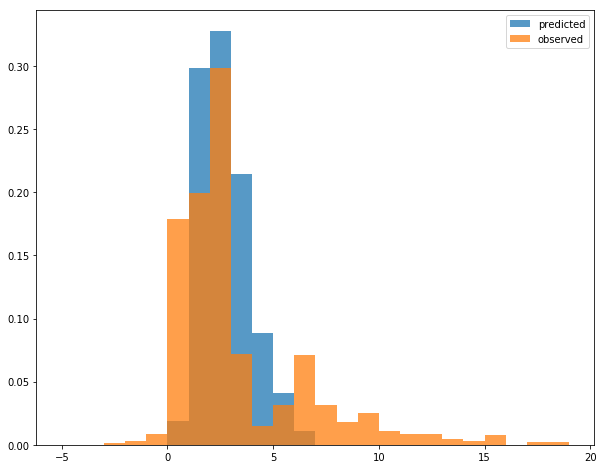

In [96]:
plt.figure(figsize=(10, 8))
plt.hist(pd.Series(y_pred), bins=range(-5,20), alpha=0.75, density=True, label='predicted')
plt.hist(pd.Series(y_test.ravel()), bins=range(-5,20), alpha=0.75, density=True, label='observed')
plt.legend()
plt.show()

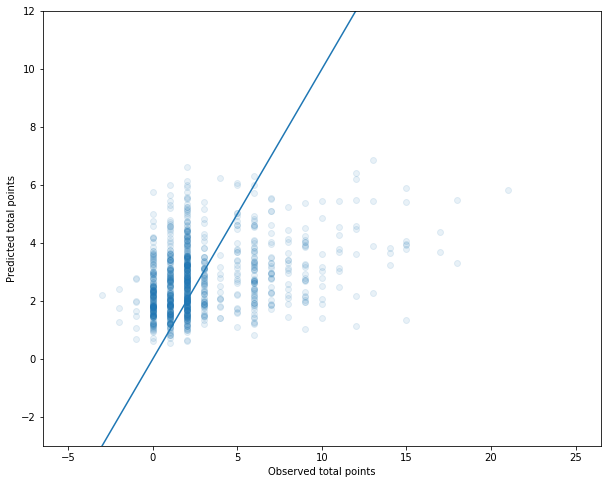

In [97]:
plt.figure(figsize=(10, 8))
plt.scatter(pd.Series(y_test.ravel()), pd.Series(y_pred), alpha=0.1)
plt.plot(np.linspace(-5, 25), np.linspace(-5, 25))
plt.ylabel('Predicted total points')
plt.xlabel('Observed total points')
plt.ylim((-3, 12))
plt.show()

## Summary

In [98]:
pd.DataFrame([
    ('XGBoost', test_loss[0], test_loss[1], test_loss[2]),
], columns=['model', 'MAE', 'MSE', 'r2'])

,model,MAE,MSE,r2
0,XGBoost,2.16324,9.229075,0.113171


In [99]:
pd.DataFrame([
    ('XGBoost', test_loss_full[0], test_loss_full[1], test_loss_full[2]),
], columns=['model', 'MAE', 'MSE', 'r2'])

,model,MAE,MSE,r2
0,XGBoost,0.024056,0.001177,0.999877
